In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error

In [2]:
df_first1 = pd.read_csv('bitdata.csv')
print((df_first1.shape))

(4857377, 8)


In [3]:

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows





# Sorting and Filtering bitdata.csv file into List of Tuples and Removing unwanted Lines

In [4]:
header = None
product_categories = set()
i = 0
line1 = []
T = []

with open('bitdata.csv') as file:
    
    
    for line in file:
        if not line.strip():
            continue 
        if not header: 
            header = line.strip().split(',')
            continue
        if 'NaN' in line:
            continue

        line1 = line.strip().split(',')
#         print(line1)
        
        T.append(tuple(line1))
        
        i = i + 1  
        if i == 1000: 
               break
#    print(T)
    final_list =[]
    for k in T:
        empty_list =[]
        for j in k:
            empty_list.append(float(j))
        final_list.append(tuple(empty_list))
#    print(final_list)


        

In [5]:
len(final_list)

1000

In [6]:
conn = create_connection('normalized1b.db')

In [36]:
#Creating Databases - History Data

In [7]:

create_table_sql = """CREATE TABLE HistoryData (
    Timestamp INTEGER NOT NULL PRIMARY KEY,
    Open INTEGER NOT NULL,    
    High INTEGER NOT NULL, 
    Low  INTEGER NOT NULL,
    close INTEGER NOT NULL,
    VolumeBTC INTEGER NOT NULL,
    VolumeCurrency INTEGER NOT NULL,
    WeightedPrice INTEGER NOT NULL
    );
"""
create_table(conn, create_table_sql, drop_table_name='HistoryData')

# def insert_Cty(conn, Values):
#     sql = '''INSERT INTO HistoryData(Timestamp,Open,High,Low,Volume_(BTC),Volume_(Currency),Weighted_Price)
#              Values(?,?,?,?,?,?,?)'''  
#     cur = conn.cursor()
#     cur.execute(sql, Values)
#     return cur.lastrowid

# with conn:
#     for i in final_list:     
#         insert_Cty(conn,i)

with conn:
        cur = conn.cursor()
        cur.executemany("INSERT INTO HistoryData(Timestamp,Open,High,Low,close,VolumeBTC,VolumeCurrency,WeightedPrice) Values(?,?,?,?,?,?,?,?)", final_list)
        
        

In [37]:
#Created New SIGNAL variable and Creation of New table - Target ( Normalization)

In [8]:
sql_statement = "select Timestamp, close, round(avg(close) over(order by Timestamp ROWS BETWEEN 10 PRECEDING AND CURRENT ROW), 2) as SMA1, round(avg(close) over(order by Timestamp ROWS BETWEEN 60 PRECEDING AND CURRENT ROW), 2) as sma2, CASE WHEN round(avg(close) over(order by Timestamp ROWS BETWEEN 10 PRECEDING AND CURRENT ROW), 2)>round(avg(close) over(order by Timestamp ROWS BETWEEN 60 PRECEDING AND CURRENT ROW), 2) THEN 1.0 ELSE 0.0 END AS signal from HistoryData"

std = execute_sql_statement(sql_statement, conn)

In [9]:
create_table_sql = """CREATE TABLE Target (
    Timestamp INTEGER NOT NULL PRIMARY KEY,
    close INTEGER NOT NULL,
    SMA1 INTEGER NOT NULL,
    SMA2 INTEGER NOT NULL,
    SIGNAL INTEGER
    );
"""
create_table(conn, create_table_sql, drop_table_name='Target')

with conn:
        cur = conn.cursor()
        cur.executemany("INSERT INTO Target(Timestamp,close,SMA1,SMA2,SIGNAL) Values(?,?,?,?,?)", std)

In [38]:
#Loading tables in to dataframes

In [10]:
query1='''SELECT * FROM  Target'''
df_Table1=pd.read_sql_query(query1,conn)
query2='''SELECT * FROM  HistoryData'''
df_table2=pd.read_sql_query(query2,conn)

In [11]:
df_Table1.head()

,Timestamp,close,SMA1,SMA2,SIGNAL
0,1325317920,4.39,4.39,4.39,0
1,1325346600,4.39,4.39,4.39,0
2,1325350740,4.57,4.45,4.45,0
3,1325350800,4.58,4.48,4.48,0
4,1325391360,4.58,4.50,4.50,0


In [12]:
dataset = pd.concat([df_table2, df_Table1], axis=1)
dataset.head()

,Timestamp,Open,High,Low,close,VolumeBTC,VolumeCurrency,WeightedPrice,Timestamp,close,SMA1,SMA2,SIGNAL
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,1325317920,4.39,4.39,4.39,0
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,1325346600,4.39,4.39,4.39,0
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,1325350740,4.57,4.45,4.45,0
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,1325350800,4.58,4.48,4.48,0
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,1325391360,4.58,4.50,4.50,0


In [13]:
dataset['SIGNAL'].unique()

array([0, 1])

############## Model BUilding- MACHINE LEARNING ALGORITHM ############## 

In [14]:
dataset = dataset.loc[:,~dataset.columns.duplicated()]  # removing column duplicates
del dataset['Timestamp']   # tme stamp column not required

In [15]:
## Outliers

<AxesSubplot:>

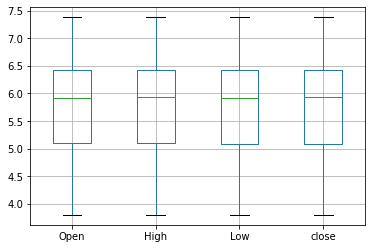

In [16]:
import matplotlib.pyplot as plt
dataset.boxplot(column=['Open','High','Low','close'])#,'VolumeBTC','VolumeCurrency','WeightedPrice'])

In [17]:
## Correlation Matrix

In [18]:

dataset.head()

,Open,High,Low,close,VolumeBTC,VolumeCurrency,WeightedPrice,SMA1,SMA2,SIGNAL
0,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,4.39,4.39,0
1,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,4.39,4.39,0
2,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,4.45,4.45,0
3,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,4.48,4.48,0
4,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,4.50,4.50,0


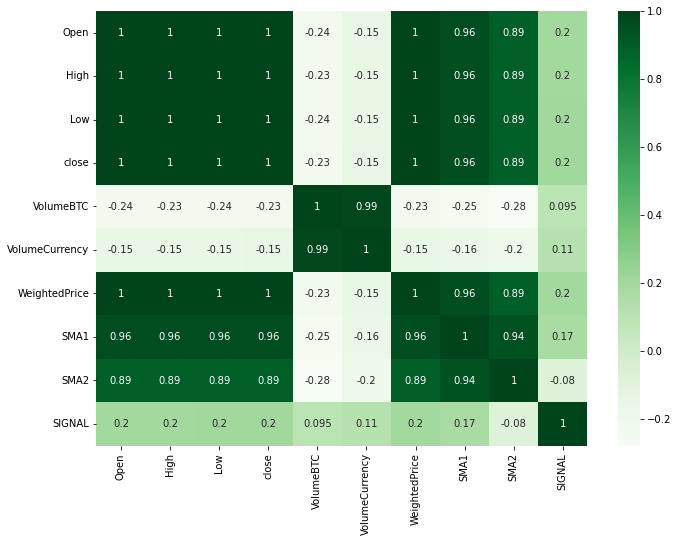

In [19]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

corr = dataset.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

## that's why only close price is choosen for moving avergae concept

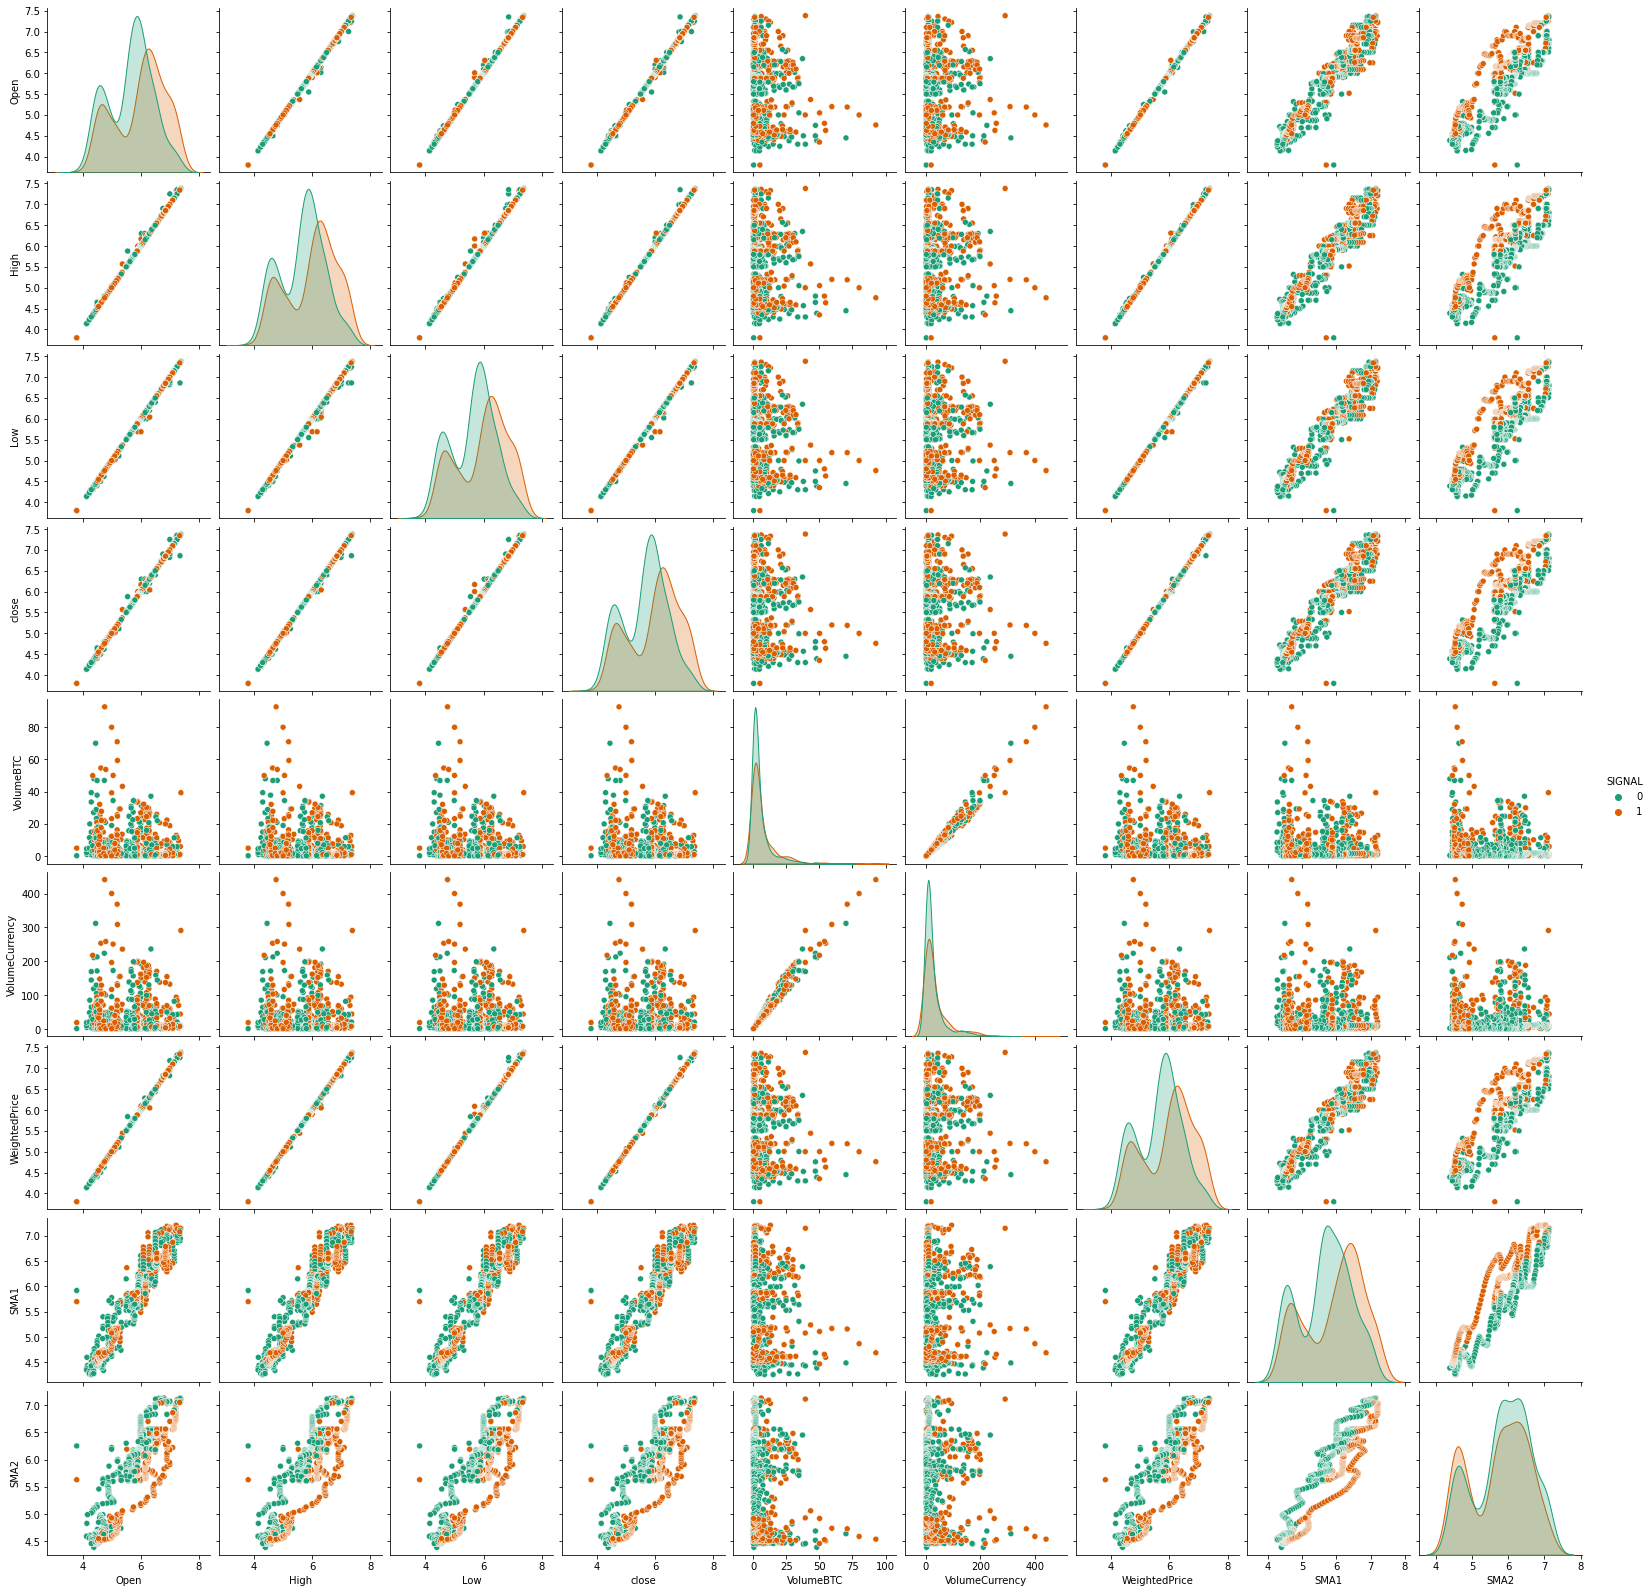

In [20]:
import seaborn as sns
sns.pairplot(dataset,hue='SIGNAL',palette='Dark2')

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## SVM Cassifier 

In [22]:
## Before Tuning

In [23]:
x = dataset[['Open','High','Low','close','VolumeBTC','VolumeCurrency','WeightedPrice','SMA1','SMA2']]
y = dataset[['SIGNAL']]

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20)

In [25]:
model=SVC()
model.fit(x_train,y_train)
predict=model.predict(x_test)
accuracy_score(y_test,predict)

/Users/yeshwanthnelakurthy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.605

In [26]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [27]:
grid = GridSearchCV(SVC(),parameters)
grid.fit(x_train,y_train)


/Users/yeshwanthnelakurthy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yeshwanthnelakurthy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yeshwanthnelakurthy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/yeshwanthnelakurthy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [28]:
print(grid.best_estimator_)

SVC(C=10, kernel='linear')


In [29]:
grid_predictions = grid.predict(x_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[106   6]
 [  0  88]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       112
           1       0.94      1.00      0.97        88

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



# KNN Classifier

In [30]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Training the K-NN model on the Training set

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)


/Users/yeshwanthnelakurthy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


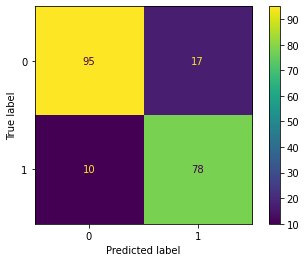

In [31]:
plot_confusion_matrix(classifier, x_test, y_test) 

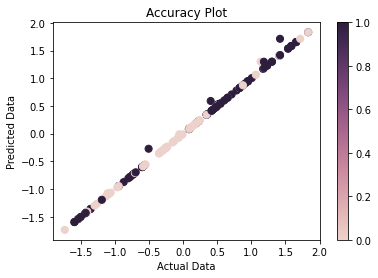

In [32]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
     x_test[:, 0], x_test[:, 1], c=y_pred, s=50, cmap=cmap
 )
f.colorbar(points)
plt.xlabel('Actual Data') 
plt.ylabel('Predicted Data') 
  
# displaying the title
plt.title("Accuracy Plot")

plt.show()

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       112
           1       0.82      0.89      0.85        88

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200



# RANDOM FOREST

In [34]:
from sklearn.ensemble import RandomForestClassifier
classifier3 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
classifier3.fit(x_train, y_train)
y_pred = classifier3.predict(x_test)

/var/folders/rh/24nstj9d1jggx63sqd127qwh0000gn/T/ipykernel_2123/2267071737.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier3.fit(x_train, y_train)


In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       112
           1       0.90      0.89      0.89        88

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200



# THE END